#**Exoplanet Detection and Classification Project**

#**Step 1: Define the Objective**

**Objective: Detect and classify exoplanets using data from missions like Kepler. The goal is to identify potential exoplanets by analyzing light curves and classify them as either exoplanetary transits or other phenomena (e.g., binary stars).**

#**Step 2: Set Up Your Environment**

In [2]:
pip install lightkurve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 28.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.8/910.8 kB 54.8 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=a2943a409f076a6e8be742921ed85cd71ff921f91ec0b902ddcae154c0487168
  Stored in directory: /root/.cache/pip/wheels/3c/ea/60/8d1c9fbbc99492a1775b36a5e29c8c1ef309cc5821bd5a219d
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50451 sha256=bb76d12bfaaadd09a286ab392843304422f1d391058b13aadba3e3a5c2a3d88a
  Stored in directory: /root/.cache/pip/wheels/3e/b8/c5/b553

In [3]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from astropy.timeseries import BoxLeastSquares
from astropy.time import Time


from sklearn.model_selection import train_test_split , GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

#**Step 3: Gather Data**

To analyze a star with single planet , use KIC 6922244

To analyze a star with multiple planets, use KIC 10872983

<Axes: title={'center': 'Target ID: 6922244, Cadence: 11958'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

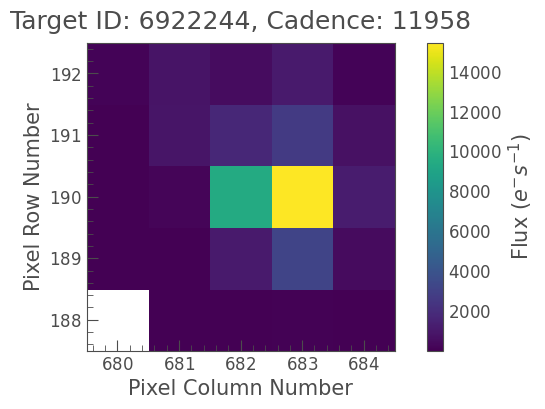

In [82]:
# Download the pixelfile for a given star
# A quarter means a quarter of a year
pixelFile = search_targetpixelfile('KIC 6922244', author="Kepler", cadence="long", quarter=4).download()
# Show a single snapshot
pixelFile.plot(frame=42)


                    flux  flux_err  centroid_col  centroid_row  cadenceno  \
time                                                                        
352.376325  43689.148438  6.631562    682.680325    190.072614      11914   
352.396758  43698.078125  6.631830    682.679939    190.072439      11915   
352.437624  43694.105469  6.631788    682.679626    190.072676      11917   
352.458058  43698.316406  6.631949    682.679788    190.072496      11918   
352.478491  43687.648438  6.631505    682.679287    190.072465      11919   

            quality  
time                 
352.376325        0  
352.396758     8192  
352.437624       16  
352.458058        0  
352.478491        0  
Index(['flux', 'flux_err', 'centroid_col', 'centroid_row', 'cadenceno',
       'quality'],
      dtype='object')


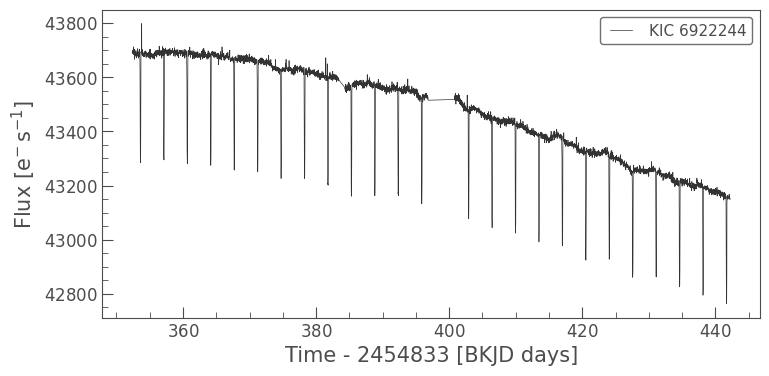

In [83]:
# Aperture masks make the image look better for analysis
pixel_to_lc = pixelFile.to_lightcurve(aperture_mask=pixelFile.pipeline_mask)
pixel_to_lc.plot()

#Data about the lightcurve data
pixel_to_lc_df = pixel_to_lc.to_pandas()
print(pixel_to_lc_df.head())
print(pixel_to_lc_df.columns)

In [84]:
# Specify the Kepler ID of the target star
target = 'KIC 6922244'  #Kepler ID

# Search for the light curve file of the specified target
search_result = lk.search_lightcurve(target, quarter=4, cadence='long')

# Print the search results to understand what data is available
print(search_result)

# Download all the light curve files from the search results
lc_files = search_result.download_all()

# Print the downloaded light curve files to understand their structure
print(lc_files)

SearchResult containing 1 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 04 2010 Kepler    1800 kplr006922244      0.0
LightCurveCollection of 1 objects:
    0: <KeplerLightCurve LABEL="KIC 6922244" QUARTER=4 AUTHOR=Kepler FLUX_ORIGIN=pdcsap_flux>


#**Step 4: Visualize Light Curve Data** & **Step 5: Data Preprocessing**

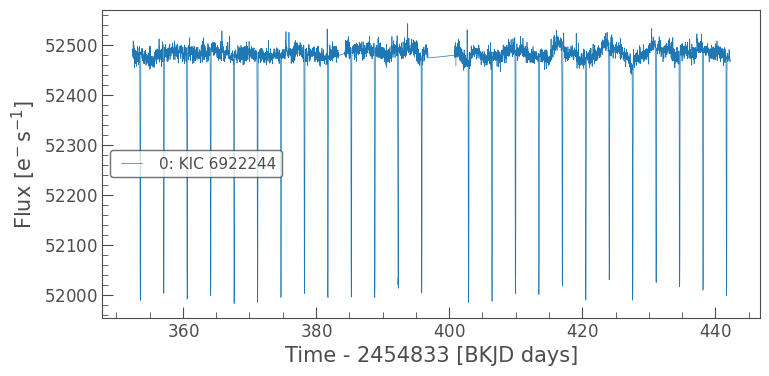

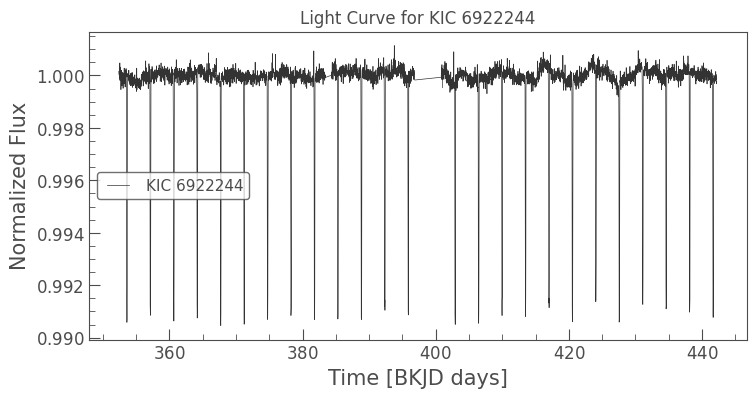

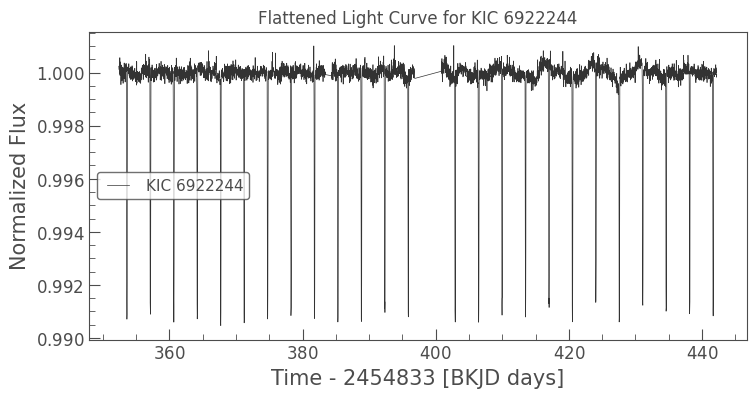

In [85]:
# Plot all the downloaded light curve files
lc_files.plot()

# Combine the light curves from all the downloaded files
lc = lc_files.PDCSAP_FLUX.stitch()

# Plot the combined light curve to visualize the star's brightness over time
lc.plot()
plt.title(f'Light Curve for {target}')
plt.xlabel('Time [BKJD days]')
plt.ylabel('Normalized Flux')
plt.show()

# We may find it easier to spot the pattern if we flatten the curve
# Remove NaN values
lc = lc.remove_nans()

# Normalize the light curve
lc = lc.normalize()

# Flatten the light curve
lc_flat = lc.flatten(window_length=901)
lc_flat.plot()
plt.title(f'Flattened Light Curve for {target}')
plt.show()

#**Step 6: Feature Extraction**

In [86]:
# Convert LightCurve to Pandas DataFrame
lc_df = lc_flat.to_pandas()

#Info about the df
print(lc_df.info())

# Display the first few rows of the DataFrame
print(lc_df.head())

# List all columns in the DataFrame
print(lc_df.columns)


<class 'pandas.core.frame.DataFrame'>
Index: 4108 entries, 352.3967580484896 to 442.20350409652747
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   flux             4108 non-null   float64
 1   flux_err         4108 non-null   float64
 2   quality          4108 non-null   int32  
 3   timecorr         4108 non-null   float32
 4   centroid_col     4108 non-null   float64
 5   centroid_row     4108 non-null   float64
 6   cadenceno        4108 non-null   int32  
 7   sap_flux         4108 non-null   float32
 8   sap_flux_err     4108 non-null   float32
 9   sap_bkg          4108 non-null   float32
 10  sap_bkg_err      4108 non-null   float32
 11  pdcsap_flux      4108 non-null   float32
 12  pdcsap_flux_err  4108 non-null   float32
 13  sap_quality      4108 non-null   int32  
 14  psf_centr1       4108 non-null   float64
 15  psf_centr1_err   4108 non-null   float32
 16  psf_centr2       4108 non-null   fl

In [89]:
# Convert the light curve to a NumPy array
time = lc_flat.time.value
flux = lc_flat.flux.value
print(flux)
# Calculate the mean and standard deviation of the flux
mean_flux = np.mean(flux)
std_flux = np.std(flux)
sigma = 10  # You can adjust this value as needed

# Detect potential transits using a simple threshold
threshold = 0.99184291 # Adjust this threshold as needed (a point below which all the expected transit points may occur)
transit_mask = flux < threshold

# Find local minima within the transit mask
peaks, _ = find_peaks(-flux, height=-threshold)

# Check if any transits were detected
if np.sum(transit_mask) == 0:
    print("No transits detected with the given threshold.")
else:
    # Initialize lists to hold the results for each transit
    transit_durations = []
    ingress_starts = []
    egress_ends = []

    # Identify contiguous segments of the transit mask
    transit_indices = np.where(transit_mask)[0]    #indices where transit_mask is True
    split_points = np.where(np.diff(transit_indices) > 1)[0] + 1
    transit_segments = np.split(transit_indices, split_points)

    # Calculate ingress start and egress end for each transit
    for segment in transit_segments:
        ingress_start = time[segment[0]]
        egress_end = time[segment[-1]]
        transit_duration = egress_end - ingress_start

        ingress_starts.append(ingress_start)
        egress_ends.append(egress_end)
        transit_durations.append(transit_duration)
    # Extract the features: depth, duration, and periodicity
    transit_depth = 1-flux[peaks].min()
    transit_periodicity = np.diff(time[peaks]).mean()

    features = {
        'depth': transit_depth,
        'duration': transit_duration,
        'periodicity': transit_periodicity
    }

    print(features)

[1.00024375 1.00011618 1.00026389 ... 1.00000978 0.99983219 0.99992858]
{'depth': MaskedNDArray(0.00953973), 'duration': 0.06130308889987646, 'periodicity': 3.3873035987492655}


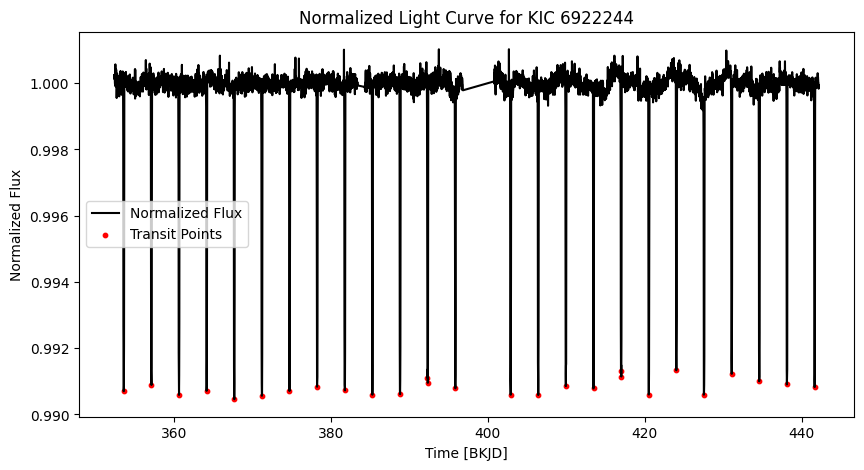

In [90]:
# Plot the normalized light curve
plt.figure(figsize=(10, 5))
plt.plot(time, flux, label='Normalized Flux', color='black')
plt.scatter(time[peaks], flux[peaks], color='red', s=10, label='Transit Points')

# Marking the transit points with red dots
plt.xlabel('Time [BKJD]')
plt.ylabel('Normalized Flux')
plt.title(f'Normalized Light Curve for {target}')
plt.legend()
plt.show()

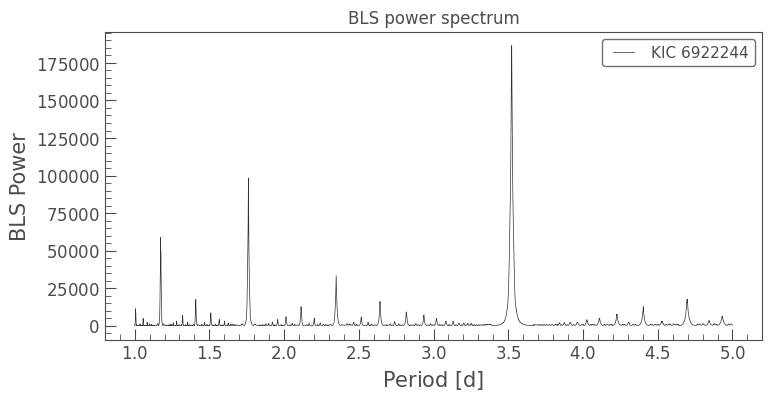

Best power: 186578.47219238934
Transit time at max power: 353.60175804848956
{'depth': <Quantity 0.00845154>, 'duration': 0.1, 'periodicity': 3.522652265226523}


In [94]:
# Use Lightkurve's built-in transit detection (BLS Method)
# Assumed period in days, adjust based on your knowledge or data
periods = np.linspace(1, 5, 10000)  # Example: searching between 1 and 30 days with 10000 steps
bls = lc_flat.to_periodogram(method='bls', period=periods, frequency_factor=500)

# Plot the BLS periodogram to inspect potential transit signals
bls.plot()
plt.title('BLS power spectrum')
plt.show()

# Extract the best-fit period and related attributes
best_power = bls.max_power
transit_time = bls.transit_time_at_max_power

print(f"Best power: {best_power}")
print(f"Transit time at max power: {transit_time}")

# Calculate the depth, duration, and periodicity of detected transits
bls_transit_depth = bls.depth_at_max_power
bls_transit_duration = bls.duration_at_max_power.to_value('d')
bls_transit_periodicity = bls.period_at_max_power.to_value('d')

bls_features = {
    'depth': bls_transit_depth,
    'duration': bls_transit_duration,
    'periodicity': bls_transit_periodicity
}

print(bls_features)

[]

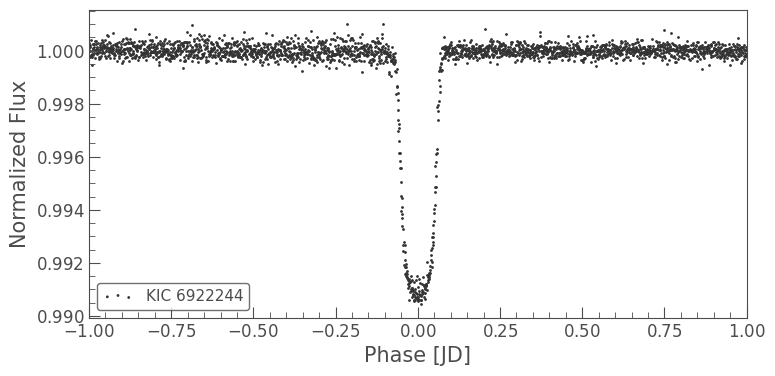

In [95]:
# Phase-fold the light curve to verify that the period and transit time corresponds to the transit signal
# This puts the frequency spikes on top of each other if we got the periodicity right in bls method
folded_lc = lc_flat.fold(period=bls_transit_periodicity,epoch_time=transit_time).scatter()
folded_lc.set_xlim(-1,1)
folded_lc.plot()

# The depth can tell you about the size, etc

# **continue if you're analyzing a multi-planetary system**

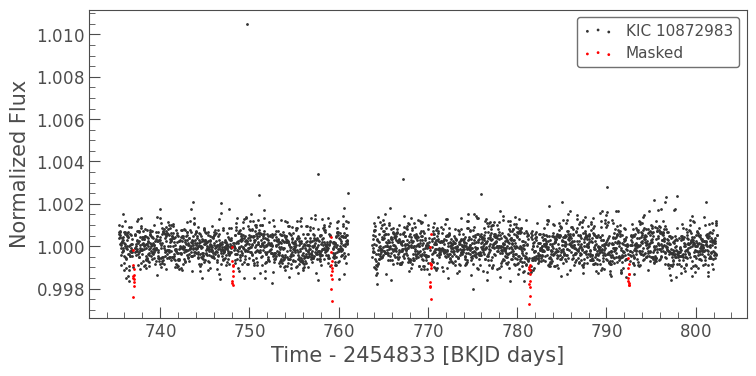

In [ ]:
# Create a cadence mask using the BLS parameters
planet_mask_1 = bls.get_transit_mask(period=bls_transit_periodicity,
                                     transit_time=transit_time,
                                     duration=bls_transit_duration)

masked_lc_1 = lc_flat[~planet_mask_1]
ax = masked_lc_1.scatter();
lc_flat[planet_mask_1].scatter(ax=ax, c='r', label='Masked');

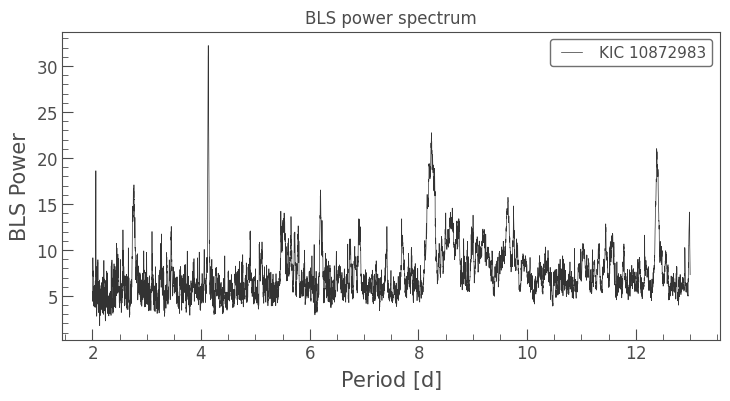

Best power: 32.22801615805955
Transit time at max power: 739.4042899629526
{'depth': <Quantity 0.00042899>, 'duration': 0.15, 'periodicity': 4.133113311331133}


In [ ]:
period = np.linspace(2, 13, 10000)
bls_1 = masked_lc_1.to_periodogram('bls', period=period, frequency_factor=500)
bls_1.plot()
plt.title('BLS power spectrum')
plt.show()

# Extract the best-fit period and related attributes
best_power_1 = bls_1.max_power
transit_time_1 = bls_1.transit_time_at_max_power

print(f"Best power: {best_power_1}")
print(f"Transit time at max power: {transit_time_1}")

# Calculate the depth, duration, and periodicity of detected transits
bls_transit_depth_1 = bls_1.depth_at_max_power
bls_transit_duration_1 = bls_1.duration_at_max_power.to_value('d')
bls_transit_periodicity_1 = bls_1.period_at_max_power.to_value('d')

bls_features_1 = {
    'depth': bls_transit_depth_1,
    'duration': bls_transit_duration_1,
    'periodicity': bls_transit_periodicity_1
}

print(bls_features_1)


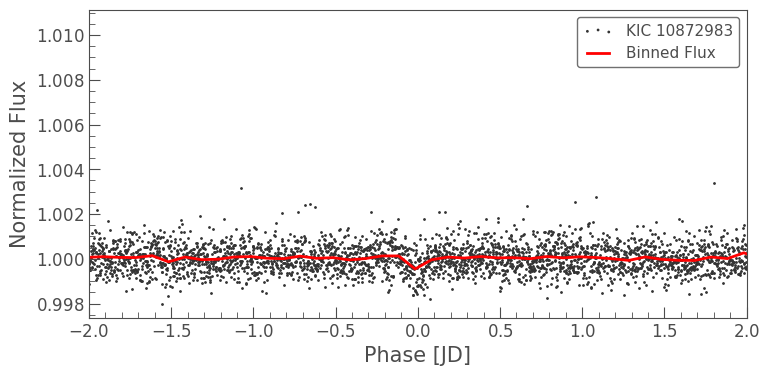

In [ ]:
ax = masked_lc_1.fold(bls_transit_periodicity_1, transit_time_1).scatter()
masked_lc_1.fold(bls_transit_periodicity_1, transit_time_1).bin(.1).plot(ax=ax, c='r', lw=2, label='Binned Flux')
ax.set_xlim(-2, 2);

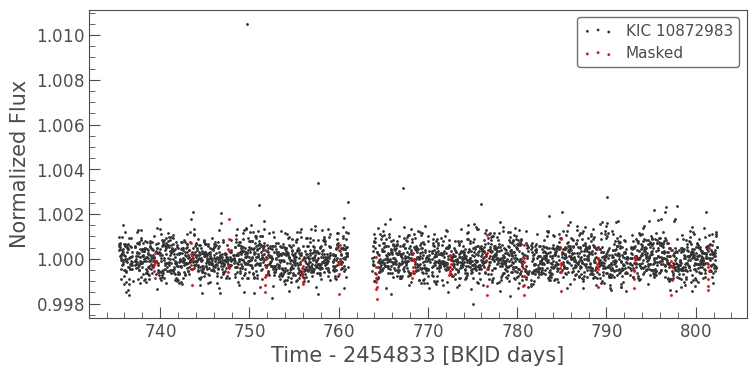

In [ ]:
planet_mask_2 = bls_1.get_transit_mask(period=bls_transit_periodicity_1,
                                     transit_time=transit_time_1,
                                     duration=bls_transit_duration_1)

masked_lc_2 = masked_lc_1[~planet_mask_2]
ax = masked_lc_2.scatter();
masked_lc_1[planet_mask_2].scatter(ax=ax, c='r', label='Masked');

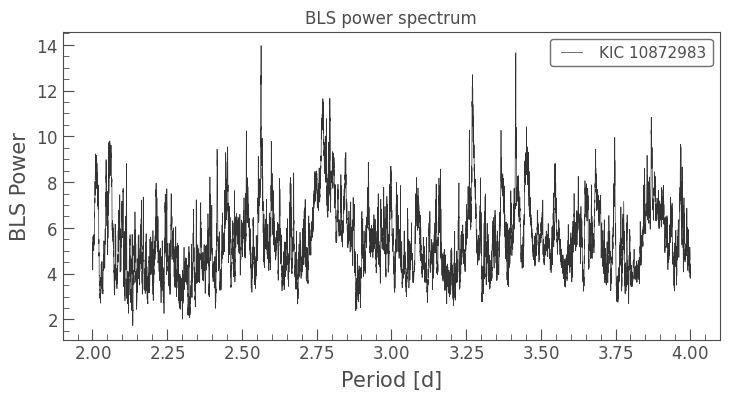

Best power: 13.963991681414125
Transit time at max power: 736.5242899629526
{'depth': <Quantity 0.00040436>, 'duration': 0.05, 'periodicity': 2.564256425642564}


In [ ]:
period = np.linspace(2, 4, 10000)
bls_2 = masked_lc_2.to_periodogram('bls', period=period, frequency_factor=500)
bls_2.plot()
plt.title('BLS power spectrum')
plt.show()

# Extract the best-fit period and related attributes
best_power_2 = bls_2.max_power
transit_time_2 = bls_2.transit_time_at_max_power

print(f"Best power: {best_power_2}")
print(f"Transit time at max power: {transit_time_2}")

# Calculate the depth, duration, and periodicity of detected transits
bls_transit_depth_2 = bls_2.depth_at_max_power
bls_transit_duration_2 = bls_2.duration_at_max_power.to_value('d')
bls_transit_periodicity_2 = bls_2.period_at_max_power.to_value('d')

bls_features_2 = {
    'depth': bls_transit_depth_2,
    'duration': bls_transit_duration_2,
    'periodicity': bls_transit_periodicity_2
}

print(bls_features_2)

# **ML MODEL TRAINING**

In [ ]:
data = pd.read_csv('/content/cumulative.csv',skiprows=55)
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2745 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,1,0,...,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
9560,10128825,K07986.01,NaN,CANDIDATE,CANDIDATE,0.497,0,0,0,0,...,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757
9561,10147276,K07987.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.021,0,0,1,0,...,-236.0,4.447,0.056,-0.224,1.041,0.341,-0.114,294.16489,47.176281,15.385
9562,10155286,K07988.01,NaN,CANDIDATE,CANDIDATE,0.092,0,0,0,0,...,-128.0,2.992,0.030,-0.027,7.824,0.223,-1.896,296.76288,47.145142,10.998


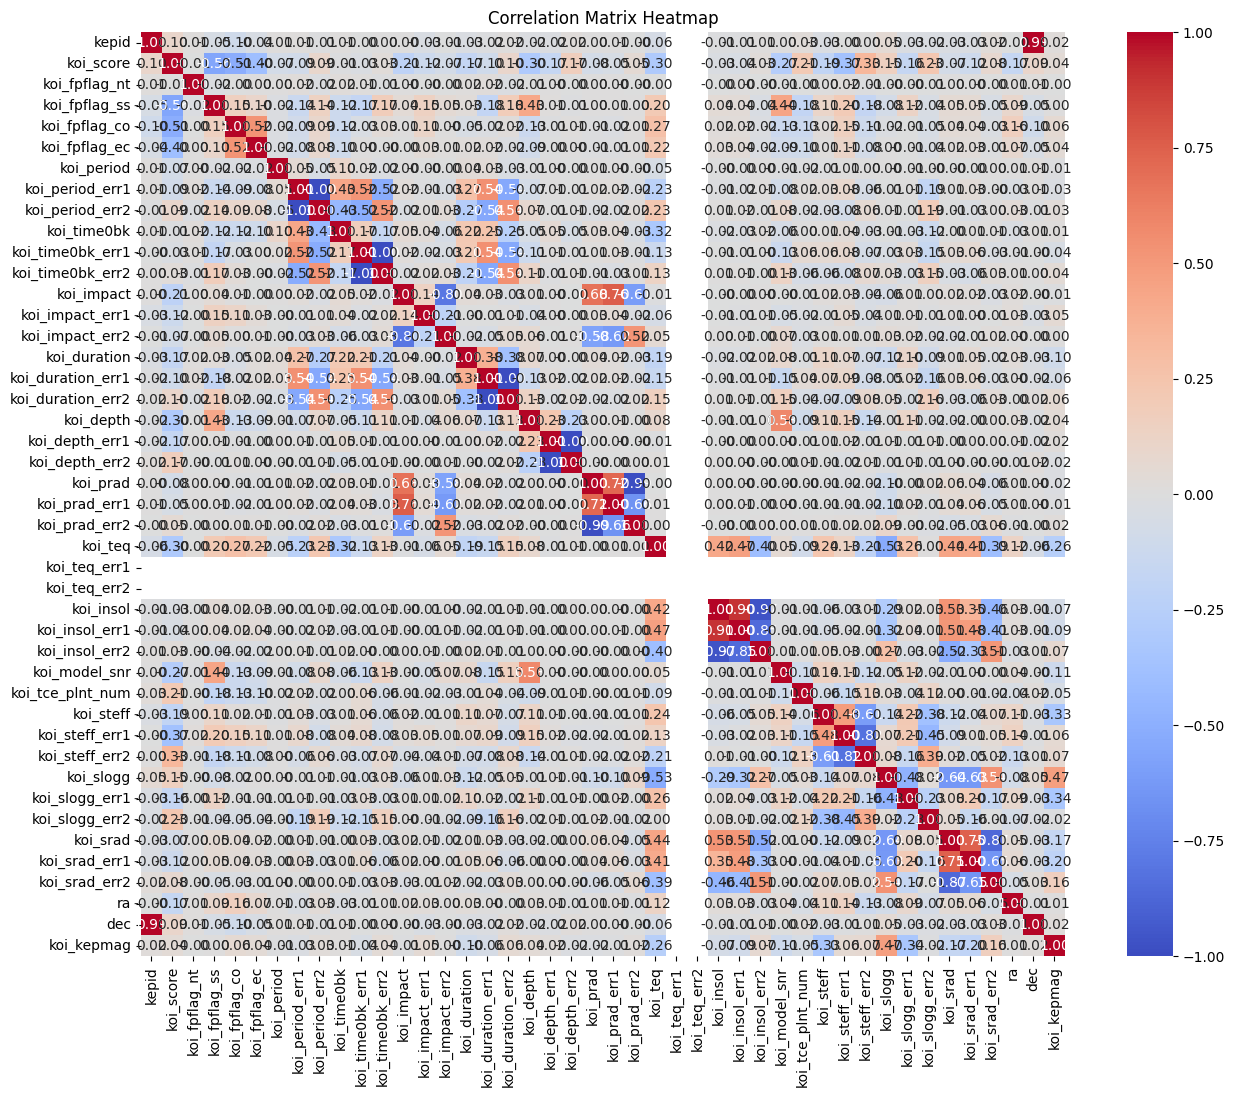

In [ ]:
# Drop non-numeric columns if they are not relevant for correlation
data_numeric = data.select_dtypes(include=[float, int])

# Compute the correlation matrix
corr_matrix = data_numeric.corr()

# Create the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
#Data preprocessing
# Copy the dataset to a new DataFrame for preprocessing
df =  data.copy()
# Drop unused/unwanted columns and error columns
df = df.drop(['kepid', 'kepoi_name', 'kepler_name', 'koi_pdisposition', 'dec', 'koi_teq', 'koi_slogg', 'koi_tce_plnt_num', 'koi_tce_delivname' ,
              'koi_period_err1','koi_period_err2',
              'koi_time0bk_err1','koi_time0bk_err2',
              'koi_impact_err1', 'koi_impact_err2',
              'koi_duration_err1','koi_duration_err2',
              'koi_depth_err1','koi_depth_err2',
              'koi_prad_err1','koi_prad_err2',
              'koi_teq_err1','koi_teq_err2',
              'koi_insol_err1','koi_insol_err2',
              'koi_steff_err1','koi_steff_err2',
              'koi_slogg_err1','koi_slogg_err2',
              'koi_srad_err1','koi_srad_err2'
              ],
                axis=1)

df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   koi_disposition  9564 non-null   object 
 1   koi_score        8054 non-null   float64
 2   koi_fpflag_nt    9564 non-null   int64  
 3   koi_fpflag_ss    9564 non-null   int64  
 4   koi_fpflag_co    9564 non-null   int64  
 5   koi_fpflag_ec    9564 non-null   int64  
 6   koi_period       9564 non-null   float64
 7   koi_time0bk      9564 non-null   float64
 8   koi_impact       9201 non-null   float64
 9   koi_duration     9564 non-null   float64
 10  koi_depth        9201 non-null   float64
 11  koi_prad         9201 non-null   float64
 12  koi_insol        9243 non-null   float64
 13  koi_model_snr    9201 non-null   float64
 14  koi_steff        9201 non-null   float64
 15  koi_srad         9201 non-null   float64
 16  ra               9564 non-null   float64
 17  koi_kepmag    

,koi_disposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_insol,koi_model_snr,koi_steff,koi_srad,ra,koi_kepmag
0,CONFIRMED,1.000,0,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,2.26,93.59,35.8,5455.0,0.927,291.93423,15.347
1,CONFIRMED,0.969,0,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,2.83,9.11,25.8,5455.0,0.927,291.93423,15.347
2,CANDIDATE,0.000,0,0,0,0,19.899140,175.850252,0.969,1.78220,10829.0,14.60,39.30,76.3,5853.0,0.868,297.00482,15.436
3,FALSE POSITIVE,0.000,0,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,891.96,505.6,5805.0,0.791,285.53461,15.597
4,CONFIRMED,1.000,0,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,2.75,926.16,40.9,6031.0,1.046,288.75488,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,FALSE POSITIVE,0.000,0,1,1,0,0.527699,131.705093,1.252,3.22210,1579.2,29.35,4500.53,453.3,5638.0,0.903,297.18875,14.082
9560,CANDIDATE,0.497,0,0,0,0,1.739849,133.001270,0.043,3.11400,48.5,0.72,1585.81,10.6,6119.0,1.031,286.50937,14.757
9561,FALSE POSITIVE,0.021,0,0,1,0,0.681402,132.181750,0.147,0.86500,103.6,1.07,5713.41,12.3,6173.0,1.041,294.16489,15.385
9562,CANDIDATE,0.092,0,0,0,0,333.486169,153.615010,0.214,3.19900,639.1,19.30,22.68,14.0,4989.0,7.824,296.76288,10.998


#**Step 7: Split Data into Training and Testing Sets**

In [ ]:
features = [
    'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth', 'koi_prad','koi_srad',
      'koi_model_snr',  'koi_score',  'koi_impact','koi_insol', 'koi_steff',
    'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
    'koi_kepmag','ra'
]

# Drop rows with missing values in the selected features
#df = df.dropna(subset=features)
#dropping rows with null values resulted in lower accuracy, thus we decide to impute the null values

# Impute missing values
imputer = SimpleImputer(strategy='mean')
df[features] = imputer.fit_transform(df[features])

# Encode the target variable
label_encoder = LabelEncoder()
df['koi_disposition'] = label_encoder.fit_transform(df['koi_disposition'])

# Extract features and target
X = df[features]
y = df['koi_disposition']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, test_size=0.2, random_state=1, shuffle=True)

#**Step 8: Train a Machine Learning Model** & **Step 9: Evaluate Model Performance**

Results for Logistic Regression:
Accuracy: 0.8725
Precision: 0.8790
Recall: 0.8725
F1 Score: 0.8679


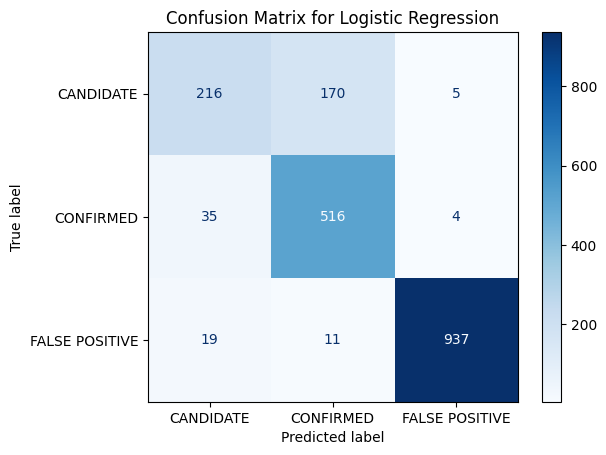



Results for Random Forest:
Accuracy: 0.9242
Precision: 0.9245
Recall: 0.9242
F1 Score: 0.9244


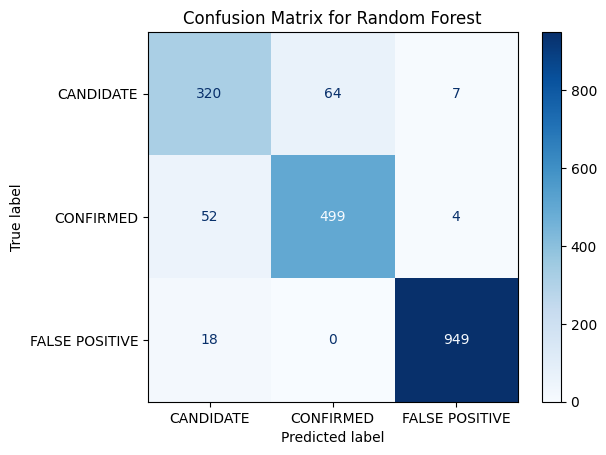



Results for Gradient Boosting:
Accuracy: 0.9232
Precision: 0.9241
Recall: 0.9232
F1 Score: 0.9236


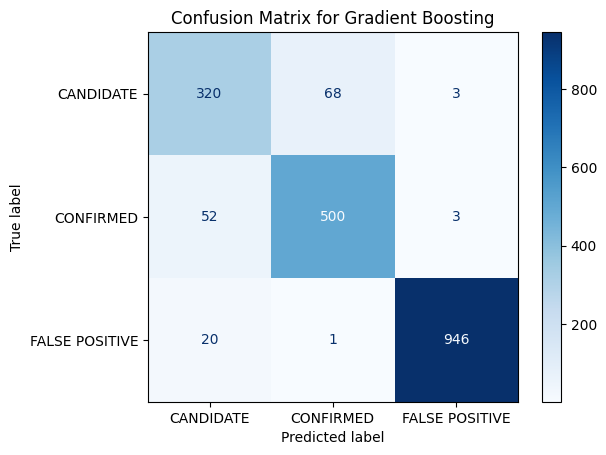

In [ ]:
# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, C= 100, solver = 'lbfgs',random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split= 5, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=300,  learning_rate= 0.2, max_depth=4, random_state=42)
}


# Train and evaluate each model
results = {}
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store the results
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

# Print the evaluation results
for model_name, metrics in results.items():
    print(f"Results for {model_name}:")
    for metric_name, metric_value in metrics.items():
        if metric_name != "Confusion Matrix":
            print(f"{metric_name}: {metric_value:.4f}")


    # Plot the confusion matrix
    cm = metrics["Confusion Matrix"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    print("\n")

#**Step 10: Continuous Improvement - Hyperparameter tuning**

In [ ]:
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

# Initialize the model
lr = LogisticRegression(max_iter=1000,random_state=42)

# Initialize GridSearchCV
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_lr.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters for Logistic Regression: {grid_search_lr.best_params_}")
print(f"Best cross-validation score: {grid_search_lr.best_score_}")

# Get the best model
best_lr_model = grid_search_lr.best_estimator_

# Evaluate the best model on the test set
accuracy_lr = best_lr_model.score(X_test, y_test)
print(f"Test set accuracy with Logistic Regression: {accuracy_lr}")

Best parameters for Logistic Regression: {'C': 100, 'solver': 'lbfgs'}
Best cross-validation score: 0.8768803336705899
Test set accuracy with Logistic Regression: 0.8724516466283324


In [ ]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10]
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best cross-validation score: {grid_search_rf.best_score_}")

# Get the best model
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the best model on the test set
accuracy_rf = best_rf_model.score(X_test, y_test)
print(f"Test set accuracy with Random Forest: {accuracy_rf}")

Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score: 0.9243243981677148
Test set accuracy with Random Forest: 0.9242028227914271


In [ ]:
# Define the parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6]
}

# Initialize the model
gb = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_gb.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters for Gradient Boosting: {grid_search_gb.best_params_}")
print(f"Best cross-validation score: {grid_search_gb.best_score_}")

# Get the best model
best_gb_model = grid_search_gb.best_estimator_

# Evaluate the best model on the test set
accuracy_gb = best_gb_model.score(X_test, y_test)
print(f"Test set accuracy with Gradient Boosting: {accuracy_gb}")

Best parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}
Best cross-validation score: 0.9286376113693899
Test set accuracy with Gradient Boosting: 0.9231573444851019
